# Plot labels and features for an episode over time

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

#something goes wrong here - no print statements possible any longer when doing reload(sys)
#solution: save and redirect the standard output to the ipython notebook
import sys  
stdout = sys.stdout

reload(sys)  
sys.setdefaultencoding('utf8')
sys.getdefaultencoding()

sys.stdout = stdout

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def plot_labels_gold(pdist_df, plot_legend=True):
    """
    pdist_df : dataframe
    """
    z = pd.Series(pdist_df.label.astype(float))
    x = pd.Series(pdist_df.time.astype(float))
    pred = pd.Series(pdist_df.prediction.astype(float))
    print pdist_df.time.astype(float).max()
    #print pdist_df[pdist_df['speaker']==speak][pdist_df['episode']==ep_to_show].current_word.unique()

    #print len(wm)
    #print len(z)
    ax = plt.subplot(111)
    ax.set_ylim([-1,3])
    #ax.set_xlim([0,15])
    
    plt.plot(x,z, label="gold")
    plt.plot(x,pred, label="prediction")
    if plot_legend:
        plt.legend(['gold', 'prediction'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

# Plot final labels and predictions for an episode
    - Plot labels as function of time
    - 0 = Mid-turn-pause
    - 1 = Speech
    - 2 = End-of-turn

18.65


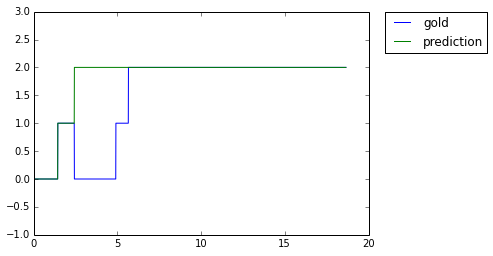

In [3]:
sp = 2
ep = 75
#ep_path = './feature_extraction/pickledEpisodes_LM'#'./pklModels_limit_train/pickledEpisodes_dur'
mode = "baseline"
ep_path = "../../../eot_detection_data/Models/lstm_5/r{}/inc_output/inc_output_r{}.0_{}.0_{}.pkl".format(sp,sp,ep,mode)
df = pd.read_pickle(ep_path)
df['time'] = [x/100.0 for x in df.index.tolist()]
plot_labels_gold(df)
#fname = ep_path+'/r'+str(sp)+'/r'+str(sp)+'_'+str(float(ep))+'.pkl'
#with open(fname,'rb') as ep_pkl:
#    pdist_df = pickle.load(ep_pkl)

# Plot features over time for an episode

In [4]:
#plot the selected features per timestep/words
#save the plot as pdf (specify the path in title_pdf)
#args: speaker, episode as int, 
#path to the pickled episodes, label of y axis, limitation of x respective y axis,
#factor to multiply values of intensity (to make them visible in the plot - the values are to small)
#title of plot, path to pdf, features with boolean value wether to plot them or not
def plot_features(sp, ep, ep_path, ylabel, x_lim, y_lim, intens_mult, title_wml,\
                  title_pdf ='some_pdf.pdf', zoom_to_words=False, show_eot=False,\
                  wm = False, wmx = False, \
                  entropy = False,\
                  zsc=False, intensm=True, \
                  rms=False, loudness=False,\
                  intenss=False, dur=False,\
                  F0=False, voiceF0=False):
    
    #fname = './../incremental-eot/pickledEpisodes/r'+str(sp)+'/r'+str(sp)+'_'+str(float(ep))+'.pkl' #MMT/r'+str(sp)+'/viterbiincremental'+str(speaker)+mode+'_'+subset+'.csv''
    fname = ep_path+'/r'+str(sp)+'/r'+str(sp)+'_'+str(int(ep))+'.pkl'
    with open(fname,'rb') as ep_pkl:
        feat_vecs_raw = pickle.load(ep_pkl)        
    #print feat_vecs_raw.keys()
    leg_lab = []
    
    labs = pd.Series(feat_vecs_raw.label.astype(float))
    
    y = pd.Series(feat_vecs_raw.wml_trigram.astype(float))
    z = pd.Series(feat_vecs_raw.wml.astype(float))
    
    b = pd.Series(feat_vecs_raw.intensity_slope.astype(float))
    c = pd.Series(feat_vecs_raw.intensity_mean.astype(float))
    d = pd.Series(feat_vecs_raw.pcm_loudness_sma.astype(float))
    e = pd.Series(feat_vecs_raw.pcm_RMSenergy_sma.astype(float))
    f = pd.Series(feat_vecs_raw.voicingFinalUnclipped_slope.astype(float))
    g = pd.Series(feat_vecs_raw.F0_slope.astype(float))
    h = pd.Series(feat_vecs_raw.entropy.astype(float))
    
    b = [intens*intens_mult for intens in list(b)]
    c = [intensitym*intens_mult for intensitym in list(c)]
    e = [rmse*1000 for rmse in list(e)]
    
    #f = [(vF*intens_mult)/100000 for vF in list(f)]
    #g = [(F0_s*intens_mult)/1000000 for F0_s in list(g)]
    
    #feat_vecs_raw = dur_feats
    a = pd.Series(feat_vecs_raw.zscore.astype(float))    
    l = pd.Series(feat_vecs_raw.duration.astype(float))#'''
    x = pd.Series(feat_vecs_raw.time_in_sec.astype(float))
    maxval = pd.Series(feat_vecs_raw.time_in_sec.astype(float)).max()
    print 'length of episode in sec ', maxval
    print len(x)
    
    #values for x labels -> words at changing of WML
    #words = feat_vecs_zsc[feat_vecs_zsc['speaker']==sp][feat_vecs_zsc['episode']==ep]
    words = feat_vecs_raw[['current_word']]
    tlist = [1.0]
    llist = ['start']
    lw = ''
    for i in range(len(words)):
        word = words.iloc[[i]].current_word.values[0]
        word.encode('utf8')
        if word != lw:
            lw = word            
            if word == u'<sil>' or word=="<null>":
                continue                
            else:
                #time = words.iloc[[i]].time_in_sec.values[0]
                #tlist.append(float(time))
            
                word = word.lower()
                word = word.replace('<','')
                word = word.replace('>','')
                word = word.replace('ä','ae')
                word = word.replace('ö','oe')
                word = word.replace('ü','ue')
                #word += '_'+str(time)
                llist.append(word)
            print word
    llist = [llist[0]]+llist[1:]
                
    time_list = list(x)
    wml_vals = list(z)
    last_wml = wml_vals[0]
    eot_time = -1
    for i in range(len(list(wml_vals))):
        time = float(time_list[i])
        if wml_vals[i] != last_wml:
            tlist.append(time)
            llist[len(tlist)-1] = str(time)+' '+llist[len(tlist)-1] 
            last_wml = wml_vals[i]
        
        if eot_time==-1 and labs[i] == 2.0:
            eot_time = float(time_list[i])            
    
    ######## save to pdf #########
    with PdfPages(title_pdf) as pdf:
        
        fig = plt.figure(figsize=(7, 5))
        
        ax1 = fig.add_subplot(111)
        #ax2 = ax1.twiny()
        
        if zoom_to_words == True:
            ax1.set_xlim(x_lim[0], tlist[-1]+2)
        else:
            ax1.set_xlim(x_lim[0], x_lim[1])
        ax1.set_ylim(y_lim[0], y_lim[1])
        
        handled_lines = []
        
        if dur == True:
            line0, = plt.plot(x,l, label='duration')
            handled_lines.append(line0)
            leg_lab.append('duration')
        if wmx==True:
            line1, = plt.plot(x,y, label='WML\ntrigram' )
            handled_lines.append(line1)
            leg_lab.append('WML\ntrigram')
        if wm==True:
            line2, = plt.plot(x,z, label='WML')
            handled_lines.append(line2)
            leg_lab.append('WML')
        if zsc==True:
            line3, = plt.plot(x,a, label='zscore')
            handled_lines.append(line3)
            leg_lab.append('zscore')
        if intensm==True:
            line4, = plt.plot(x,b, label='intensity mean')
            handled_lines.append(line4)
            leg_lab.append('intens_mean')
        if intenss==True:
            line5, = plt.plot(x,c, label='intensity slope')
            handled_lines.append(line5)
            leg_lab.append('Intensity slope')
        if rms==True:
            line6, = plt.plot(x,e, label='RMS')
            handled_lines.append(line6)
            leg_lab.append('RMS')
        if loudness==True:
            line7, = plt.plot(x,d, label='loudness')
            handled_lines.append(line7)
            leg_lab.append('loudness')    
        if voiceF0 == True:
            line8, = plt.plot(x, f, label = 'voicingFinalUnclipped_slope')
            handled_lines.append(line8)
            leg_lab.append('voicingFinalUnclipped')
        if F0 == True:
            line9, = plt.plot(x, f, label = 'F0_slope')
            handled_lines.append(line9)
            leg_lab.append('F0_slope')
        if entropy == True:
            line10, = plt.plot(x, h, label= 'entropy')
            handled_lines.append(line10)
            leg_lab.append('inv(Perplexity)')
        if title_wml != '':
            plt.title(title_wml)
            
            #print type(word)
        #for t in tlist: 
        #    plt.plot([t, t], [-10, 5], 'k-', lw=.5)        
        #plt.xlabel("time in seconds")
    
        #xticks labels
        #plt.xlabel("words")
        #plt.xticks(tlist,llist,rotation=70,  fontsize = 8)
        
        ax1.set_xticks(tlist)
        ax1.set_xticklabels(llist, rotation=70,  fontsize = 8)
        ax1.set_xlabel(r"words")
                
        plt.margins(.7)
        #plt.ylabel(r"zscore:sec, intensity:freq, wml:prob")
        ax1.set_ylabel(ylabel)
        #plt.legend(leg_lab,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #line, = plt.plot(wml_values, label="WML trigram" etc....
            
        """
        new_tick_labels = np.array([str(t) for t in tlist])
        
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(tlist)
        ax2.set_xticklabels(new_tick_labels, rotation=70,  fontsize = 8)
        ax2.set_xlabel(r"time in sec")
        """ 
        
        #EOT line
        #plt.plot([tlist[-1]*100, tlist[-1]*100], [tlist[-1]*100+100, tlist[-1]*100+100], 'k-', lw=2)
        if show_eot:
            ax1.plot([eot_time,eot_time], [-3,3], 'k-', lw=1)
            ax1.text(eot_time+0.1, 1, "EOT", rotation=90, verticalalignment='center')
        
        plt.legend(leg_lab, loc=4, borderaxespad=0.2)
    

        #plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
        #plt.title('Page One')
        
        #plt.gcf().subplots_adjust(bottom=0.15)
        plt.tight_layout()
        pdf.savefig()  # saves the current figure into a pdf page
        
    ##############################
    
        plt.show()
    
    return

In [5]:
#use_ep = {2:4,3:4,4:4,5:4,6:7,7:4}

length of episode in sec  17.71
1771
aehm
unten
rechts
das
einzige
gruene
symbol


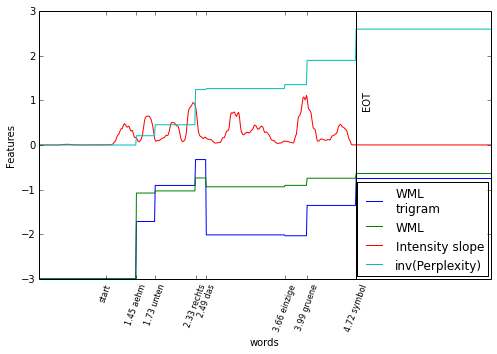

In [6]:
sp = 4
ep = 31
#ep_path = './pklModels_limit_train/pickledEpisodes_30012017'#_dur'
#ep_path = './../incremental-eot/Data/pickledEpisodes_old'
#ep_path = './pklModels_limit_train/pickledEpisodes_dur'
#ep_path = './feature_extraction_modularized/pickledEpisodes_higherOrderTextGridData'
#ep_path = './feature_extraction_modularized/pickled_episodes_old_wav13sec'#merge'
#pdf_path = "../../Paper/Interspeech/submission/FeaturePlot.pdf"
pdf_path = "Episode_{0}_{1}.pdf".format(sp, ep)
ep_path = "../../../eot_detection_data/Data/pickled_episodes"
plot_features(sp,ep, ep_path, ylabel='Features',\
              x_lim=[0,17], y_lim=[-3,3], intens_mult = 100000,\
              title_pdf=pdf_path,\
              title_wml='', zoom_to_words=True, show_eot=True,\
              wm = True, wmx = True,\
              zsc=False, dur=False, entropy = True,\
              loudness=False, rms=False,\
              intensm=False, intenss=True,
              F0=False, voiceF0=False)